<a href="https://colab.research.google.com/github/Aomaphisara/bsc_dpdm22/blob/main/Association_rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data



In [137]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [138]:
#เชื่อม google drive 
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
data_train = pd.read_csv('/content/drive/MyDrive/bsc_DPDM_data/Train.csv', sep=',')
data_test = pd.read_csv('/content/drive/MyDrive/bsc_DPDM_data/Test.csv', sep=',')
existing  = data_train.drop('Var_1', axis=1)
new  = data_test.drop('Var_1', axis=1)
existing.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,A


## existing_customers

In [140]:
# 1. Remove duplicated rows (38 in total)
existing.drop_duplicates(inplace=True)

# 2. Create a calculated column (Work_Experience_to_Age_Ratio) that could potentialy be a relevant feature to the model (to be tested later)
existing["Work_Experience_to_Age_Ratio"] = existing["Work_Experience"] / existing["Age"]

# 3. Treat missing values:
#    *   3.1 Ever_Married: consider missing values as No
#    *   3.2 Graduated: consider missing values as No
#    *   3.3 Profession: delete (it´s not representative the amount of blanks)
#    *   3.4 Family_Size: mean
#    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
#    *   3.6 Work_Experience: estimate based on Age
existing["Ever_Married"].fillna("No", inplace=True)
existing["Graduated"].fillna("No", inplace=True)
existing.dropna(subset=["Profession"], inplace=True)
existing["Family_Size"].fillna(existing["Family_Size"].mean(), inplace=True)
existing["Work_Experience"].replace(0, np.nan, inplace=True)
existing["Work_Experience"].fillna(existing["Work_Experience"].sum() / existing["Age"].sum() * existing["Age"], inplace=True)
existing["Work_Experience_to_Age_Ratio"].replace(0, np.nan, inplace=True)
existing["Work_Experience_to_Age_Ratio"].fillna(existing["Work_Experience"] / existing["Age"], inplace=True)

# 4. Remove column ID as it´s not important to the model
existing.drop(["ID"], axis=1, inplace=True)

# 5. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies
existing = pd.concat([existing, pd.get_dummies(existing["Gender"], prefix="Gender")], axis=1)
existing = pd.concat([existing, pd.get_dummies(existing["Ever_Married"], prefix="Ever_Married")], axis=1)
existing= pd.concat([existing, pd.get_dummies(existing["Graduated"], prefix="Graduated")], axis=1)
existing = pd.concat([existing, pd.get_dummies(existing["Profession"], prefix="Profession")], axis=1)
existing["Spending_Score_Level"] = existing["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
#target variable for the ML model (label encoding)
existing["Segmentation_Level"] = existing["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
existing = pd.concat([existing, pd.get_dummies(existing["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(existing[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

# 6. Convert all numerical variables (Age, Work_Experience, Family_Size, Work_Experience_to_Age_Ratio) to categorical ranges (to be used in next step when analyzing correlations)
existing["Age_Range"] = np.where(existing.Age>=60, "60+", np.where(existing.Age>=50, "50-60", np.where(existing.Age>=40, "40-50", np.where(existing.Age>=30, "30-40", np.where(existing.Age>=18, "18-30", "18-")))))
existing["Work_Experience_Range"] = np.where(existing.Work_Experience>=10, "10+", np.where(existing.Work_Experience>=5, "5-10", "0-5"))
existing["Family_Size_Range"] = np.where(existing.Family_Size>=6, "6+", np.where(existing.Family_Size>=3, "3-6", "0-3"))
existing["Work_Experience_to_Age_Ratio_Range"] = np.where(existing.Work_Experience_to_Age_Ratio>=0.5, "0.5+", np.where(existing.Work_Experience_to_Age_Ratio>=0.4,
                                                                                                                   "0.4-0.5", np.where(existing.Work_Experience_to_Age_Ratio>=0.3,
                                                                                                                    "0.3-0.4", np.where(existing.Work_Experience_to_Age_Ratio>=0.2,
                                                                                                                    "0.2-0.3", np.where(existing.Work_Experience_to_Age_Ratio>=0.1,
                                                                                                                    "0.1-0.2", "0+")))))


In [141]:
existing.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_Experience_to_Age_Ratio,...,Spending_Score_Level,Segmentation_Level,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Age_Range,Work_Experience_Range,Family_Size_Range,Work_Experience_to_Age_Ratio_Range
0,Male,No,22,No,Healthcare,1.000000,Low,4.0,D,0.045455,...,1,4,0,0,0,1,18-30,0-5,3-6,0+
1,Female,Yes,38,Yes,Engineer,2.077749,Average,3.0,A,0.054678,...,2,1,1,0,0,0,30-40,0-5,3-6,0+
2,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,B,0.014925,...,1,2,0,1,0,0,60+,0-5,0-3,0+


In [142]:
existing.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Segmentation',
       'Work_Experience_to_Age_Ratio', 'Gender_Female', 'Gender_Male',
       'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level', 'Segmentation_Level',
       'Segmentation_A', 'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Age_Range', 'Work_Experience_Range', 'Family_Size_Range',
       'Work_Experience_to_Age_Ratio_Range'],
      dtype='object')

In [143]:
existing1 = existing[['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession','Spending_Score_Level','Segmentation'
       ,'Work_Experience_Range','Family_Size_Range']]
existing1

,Gender,Ever_Married,Age_Range,Graduated,Profession,Spending_Score_Level,Segmentation,Work_Experience_Range,Family_Size_Range
0,Male,No,18-30,No,Healthcare,1,D,0-5,3-6
1,Female,Yes,30-40,Yes,Engineer,2,A,0-5,3-6
2,Female,Yes,60+,Yes,Engineer,1,B,0-5,0-3
3,Male,Yes,60+,Yes,Lawyer,3,B,0-5,0-3
4,Female,Yes,40-50,Yes,Entertainment,3,A,0-5,6+
...,...,...,...,...,...,...,...,...,...
8062,Male,Yes,40-50,Yes,Artist,3,B,0-5,3-6
8064,Male,No,30-40,No,Executive,1,D,0-5,3-6
8065,Female,No,30-40,Yes,Healthcare,1,D,0-5,0-3
8066,Female,No,18-30,Yes,Healthcare,1,B,0-5,3-6


In [144]:
existing1.columns

Index(['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'],
      dtype='object')

In [145]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [146]:
# Performing one-hot encoding
existing1_encode = pd.get_dummies(existing1, columns=['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'])
# Printing the encoded data
print(existing1_encode.head())

   Gender_Female  Gender_Male  Ever_Married_No  Ever_Married_Yes  \
0              0            1                1                 0   
1              1            0                0                 1   
2              1            0                0                 1   
3              0            1                0                 1   
4              1            0                0                 1   

   Age_Range_18-30  Age_Range_30-40  Age_Range_40-50  Age_Range_50-60  \
0                1                0                0                0   
1                0                1                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                1                0   

   Age_Range_60+  Graduated_No  ...  Segmentation_A  Segmentation_B  \
0              0             1  ...               0               0   
1         

In [147]:
existing1_encode.head(3)

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,0,1,1,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [148]:
existing1_encode.columns

Index(['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes',
       'Age_Range_18-30', 'Age_Range_30-40', 'Age_Range_40-50',
       'Age_Range_50-60', 'Age_Range_60+', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level_1',
       'Spending_Score_Level_2', 'Spending_Score_Level_3', 'Segmentation_A',
       'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Work_Experience_Range_0-5', 'Work_Experience_Range_10+',
       'Work_Experience_Range_5-10', 'Family_Size_Range_0-3',
       'Family_Size_Range_3-6', 'Family_Size_Range_6+'],
      dtype='object')

In [149]:
#เปลี่ยนชื่อ columns
existing1_encode.rename(columns={'Gender_Female':'Female', 'Gender_Male':'Male'
,'Ever_Married_No':'Singer', 'Ever_Married_Yes':'Married'
,'Graduation_No':'Studying', 'Graduation_Yes':'Graduated'
,'Profession_Artist':'Artist', 'Profession_Doctor':'Doctor','Profession_Engineer':'Engineer'
,'Profession_Entertainment':'Entertainment','Profession_Executive':'Executive','Profession_Healthcare':'Healthcare'
,'Profession_Homemaker':'Homemaker','Profession_Lawyer':'Lawyer', 'Profession_Marketing':'Marketing'
,'Spending_Score_Level_1':'Spending_Score_Level1', 'Spending_Score_Level_2':'Spending_Score_Level2', 'Spending_Score_Level_3':'Spending_Score_Level3'
,'Segmentation_A':'A', 'Segmentation_B':'B','Segmentation_C':'C','Segmentation_D':'D'}, inplace=True)
existing1_encode.head(3)

,Female,Male,Singer,Married,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,A,B,C,D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,0,1,1,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [150]:
pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
import mlxtend
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

In [152]:
# Applying Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(existing1_encode, min_support=0.05, use_colnames=True)

# Generating association rules
rules0 = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sorting the rules by lift in descending order
rules0 = rules0.sort_values(['lift'], ascending=False)

# Generating association rules
rules1 = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)
rules1 = rules1.sort_values(['support'], ascending=False)

In [153]:
rules0.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17345,"(Singer, Family_Size_Range_3-6, Age_Range_18-3...","(Healthcare, Spending_Score_Level1, Graduated_No)",0.089753,0.104230,0.061304,0.683029,6.553123,0.051949,2.826037
17376,"(Healthcare, Spending_Score_Level1, Graduated_No)","(Singer, Family_Size_Range_3-6, Age_Range_18-3...",0.104230,0.089753,0.061304,0.588164,6.553123,0.051949,2.210218
17566,"(Family_Size_Range_3-6, Work_Experience_Range_...","(Healthcare, Graduated_No)",0.071501,0.107754,0.050101,0.700704,6.502797,0.042396,2.981150


In [154]:
rules1.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
306,(Work_Experience_Range_0-5),(Graduated_Yes),0.779708,0.618706,0.475453,0.609784,0.985579,-0.006957,0.977135
307,(Graduated_Yes),(Work_Experience_Range_0-5),0.618706,0.779708,0.475453,0.768464,0.985579,-0.006957,0.951437
163,(Married),(Work_Experience_Range_0-5),0.575655,0.779708,0.465760,0.809097,1.037692,0.016918,1.153947


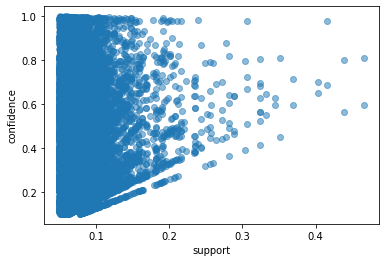

In [155]:
# Filter rules based on support and confidence thresholds
rules0 = rules0[(rules0['support'] >= 0.05) & (rules0['confidence'] >= 0.1)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules0['support'], rules0['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

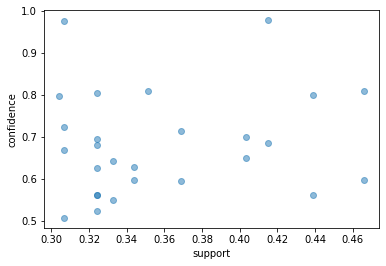

In [156]:
# Filter rules based on support and confidence thresholds
rules2 = rules0[(rules0['support'] >= 0.3) & (rules0['confidence'] >= 0.5)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules2['support'], rules2['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

## new_customers

In [157]:
# 1. Remove duplicated rows (38 in total)
new.drop_duplicates(inplace=True)

# 2. Create a calculated column (Work_Experience_to_Age_Ratio) that could potentialy be a relevant feature to the model (to be tested later)
new["Work_Experience_to_Age_Ratio"] = new["Work_Experience"] / new["Age"]

# 3. Treat missing values:
#    *   3.1 Ever_Married: consider missing values as No
#    *   3.2 Graduated: consider missing values as No
#    *   3.3 Profession: delete (it´s not representative the amount of blanks)
#    *   3.4 Family_Size: mean
#    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
#    *   3.6 Work_Experience: estimate based on Age
new["Ever_Married"].fillna("No", inplace=True)
new["Graduated"].fillna("No", inplace=True)
new.dropna(subset=["Profession"], inplace=True)
new["Family_Size"].fillna(new["Family_Size"].mean(), inplace=True)
new["Work_Experience"].replace(0, np.nan, inplace=True)
new["Work_Experience"].fillna(new["Work_Experience"].sum() / new["Age"].sum() * new["Age"], inplace=True)
new["Work_Experience_to_Age_Ratio"].replace(0, np.nan, inplace=True)
new["Work_Experience_to_Age_Ratio"].fillna(new["Work_Experience"] / new["Age"], inplace=True)

# 4. Remove column ID as it´s not important to the model
new.drop(["ID"], axis=1, inplace=True)

# 5. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies
new = pd.concat([new, pd.get_dummies(new["Gender"], prefix="Gender")], axis=1)
new = pd.concat([new, pd.get_dummies(new["Ever_Married"], prefix="Ever_Married")], axis=1)
new= pd.concat([new, pd.get_dummies(new["Graduated"], prefix="Graduated")], axis=1)
new = pd.concat([new, pd.get_dummies(new["Profession"], prefix="Profession")], axis=1)
new["Spending_Score_Level"] = new["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
#target variable for the ML model (label encoding)
new["Segmentation_Level"] = new["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
new = pd.concat([new, pd.get_dummies(new["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(new[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

# 6. Convert all numerical variables (Age, Work_Experience, Family_Size, Work_Experience_to_Age_Ratio) to categorical ranges (to be used in next step when analyzing correlations)
new["Age_Range"] = np.where(new.Age>=60, "60+", np.where(new.Age>=50, "50-60", np.where(new.Age>=40, "40-50", np.where(new.Age>=30, "30-40", np.where(new.Age>=18, "18-30", "18-")))))
new["Work_Experience_Range"] = np.where(new.Work_Experience>=10, "10+", np.where(new.Work_Experience>=5, "5-10", "0-5"))
new["Family_Size_Range"] = np.where(new.Family_Size>=6, "6+", np.where(new.Family_Size>=3, "3-6", "0-3"))
new["Work_Experience_to_Age_Ratio_Range"] = np.where(new.Work_Experience_to_Age_Ratio>=0.5, "0.5+", np.where(new.Work_Experience_to_Age_Ratio>=0.4,
                                                                                                                   "0.4-0.5", np.where(new.Work_Experience_to_Age_Ratio>=0.3,
                                                                                                                    "0.3-0.4", np.where(new.Work_Experience_to_Age_Ratio>=0.2,
                                                                                                                    "0.2-0.3", np.where(new.Work_Experience_to_Age_Ratio>=0.1,
                                                                                                                    "0.1-0.2", "0+")))))


In [158]:
new.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_Experience_to_Age_Ratio,...,Spending_Score_Level,Segmentation_Level,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Age_Range,Work_Experience_Range,Family_Size_Range,Work_Experience_to_Age_Ratio_Range
0,Female,Yes,36,Yes,Engineer,1.902553,Low,1.0,B,0.052849,...,1,2,0,1,0,0,30-40,0-5,0-3,0+
1,Male,Yes,37,Yes,Healthcare,8.000000,Average,4.0,A,0.216216,...,2,1,1,0,0,0,30-40,5-10,3-6,0.2-0.3
3,Male,Yes,59,No,Executive,11.000000,High,2.0,B,0.186441,...,3,2,0,1,0,0,50-60,10+,0-3,0.1-0.2


In [159]:
len(new)

2589

In [160]:
new.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Segmentation',
       'Work_Experience_to_Age_Ratio', 'Gender_Female', 'Gender_Male',
       'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level', 'Segmentation_Level',
       'Segmentation_A', 'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Age_Range', 'Work_Experience_Range', 'Family_Size_Range',
       'Work_Experience_to_Age_Ratio_Range'],
      dtype='object')

In [161]:
new1 = new[['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession','Spending_Score_Level','Segmentation'
       ,'Work_Experience_Range','Family_Size_Range']]
new1

,Gender,Ever_Married,Age_Range,Graduated,Profession,Spending_Score_Level,Segmentation,Work_Experience_Range,Family_Size_Range
0,Female,Yes,30-40,Yes,Engineer,1,B,0-5,0-3
1,Male,Yes,30-40,Yes,Healthcare,2,A,5-10,3-6
3,Male,Yes,50-60,No,Executive,3,B,10+,0-3
4,Female,No,18-30,No,Marketing,1,A,0-5,3-6
5,Male,Yes,40-50,Yes,Doctor,3,C,0-5,3-6
...,...,...,...,...,...,...,...,...,...
2622,Male,No,18-30,No,Healthcare,1,B,5-10,3-6
2623,Female,No,30-40,Yes,Doctor,1,A,0-5,0-3
2624,Female,No,50-60,Yes,Entertainment,1,C,0-5,0-3
2625,Male,Yes,40-50,Yes,Executive,3,C,0-5,3-6


In [162]:
new1.columns

Index(['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'],
      dtype='object')

In [163]:
# Performing one-hot encoding
new1_encode = pd.get_dummies(new1, columns=['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'])
# Printing the encoded data
print(new1_encode.head())

   Gender_Female  Gender_Male  Ever_Married_No  Ever_Married_Yes  \
0              1            0                0                 1   
1              0            1                0                 1   
3              0            1                0                 1   
4              1            0                1                 0   
5              0            1                0                 1   

   Age_Range_18-30  Age_Range_30-40  Age_Range_40-50  Age_Range_50-60  \
0                0                1                0                0   
1                0                1                0                0   
3                0                0                0                1   
4                1                0                0                0   
5                0                0                1                0   

   Age_Range_60+  Graduated_No  ...  Segmentation_A  Segmentation_B  \
0              0             0  ...               0               1   
1         

In [164]:
new1_encode.head(3)

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,1,0,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [165]:
new1_encode.columns

Index(['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes',
       'Age_Range_18-30', 'Age_Range_30-40', 'Age_Range_40-50',
       'Age_Range_50-60', 'Age_Range_60+', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level_1',
       'Spending_Score_Level_2', 'Spending_Score_Level_3', 'Segmentation_A',
       'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Work_Experience_Range_0-5', 'Work_Experience_Range_10+',
       'Work_Experience_Range_5-10', 'Family_Size_Range_0-3',
       'Family_Size_Range_3-6', 'Family_Size_Range_6+'],
      dtype='object')

In [166]:
#เปลี่ยนชื่อ columns
new1_encode.rename(columns={'Gender_Female':'Female', 'Gender_Male':'Male'
,'Ever_Married_No':'Singer', 'Ever_Married_Yes':'Married'
,'Graduation_No':'Studying', 'Graduation_Yes':'Graduated'
,'Profession_Artist':'Artist', 'Profession_Doctor':'Doctor','Profession_Engineer':'Engineer'
,'Profession_Entertainment':'Entertainment','Profession_Executive':'Executive','Profession_Healthcare':'Healthcare'
,'Profession_Homemaker':'Homemaker','Profession_Lawyer':'Lawyer', 'Profession_Marketing':'Marketing'
,'Spending_Score_Level_1':'Spending_Score_Level1', 'Spending_Score_Level_2':'Spending_Score_Level2', 'Spending_Score_Level_3':'Spending_Score_Level3'
,'Segmentation_A':'A', 'Segmentation_B':'B','Segmentation_C':'C','Segmentation_D':'D'}, inplace=True)
new1_encode.head(3)

,Female,Male,Singer,Married,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,A,B,C,D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,1,0,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [167]:
# Applying Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(new1_encode, min_support=0.05, use_colnames=True)

# Generating association rules
rules3 = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sorting the rules by lift in descending order
rules3 = rules3.sort_values(['lift'], ascending=False)

# Generating association rules
rules4 = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)
rules4 = rules4.sort_values(['support'], ascending=False)

In [168]:
rules3.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10214,"(Age_Range_60+, Family_Size_Range_0-3)","(Work_Experience_Range_0-5, Lawyer, Married)",0.142140,0.073774,0.062959,0.442935,6.003969,0.052472,1.662689
10207,"(Work_Experience_Range_0-5, Lawyer, Married)","(Age_Range_60+, Family_Size_Range_0-3)",0.073774,0.142140,0.062959,0.853403,6.003969,0.052472,5.851832
10205,"(Work_Experience_Range_0-5, Age_Range_60+, Fam...","(Lawyer, Married)",0.134415,0.078795,0.062959,0.468391,5.944430,0.052367,1.732861


In [169]:
rules4.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
163,(Married),(Work_Experience_Range_0-5),0.578216,0.787563,0.475859,0.822979,1.04497,0.020478,1.200070
162,(Work_Experience_Range_0-5),(Married),0.787563,0.578216,0.475859,0.604218,1.04497,0.020478,1.065698
307,(Graduated_Yes),(Work_Experience_Range_0-5),0.611433,0.787563,0.472383,0.772584,0.98098,-0.009159,0.934134


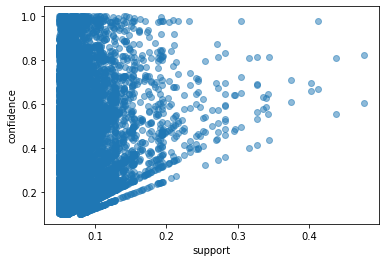

In [170]:
# Filter rules based on support and confidence thresholds
rules5 = rules3[(rules3['support'] >= 0.05) & (rules3['confidence'] >= 0.1)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules5['support'], rules5['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

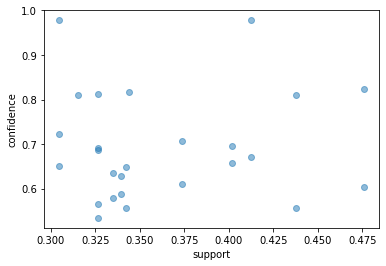

In [171]:
# Filter rules based on support and confidence thresholds
rules6 = rules3[(rules3['support'] >= 0.3) & (rules3['confidence'] >= 0.5)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules6['support'], rules6['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

## Predict the new customer group

To prepare the data for association rule mining and predict the new customer group, you can follow these steps:

1.Load the existing customer data: Load the existing customer data into a pandas dataframe.

2.Preprocess the data: Preprocess the data as needed. You may need to fill in missing values, handle outliers, and encode categorical variables.

3.Divide customers into groups: Divide the existing customers into four groups (A, B, C, D) based on their characteristics. You can use clustering algorithms such as k-means or hierarchical clustering to group the customers.

4.Associate customer groups with their characteristics: Once you have the four customer groups, analyze their characteristics and associate each group with their specific characteristics. You can use techniques such as decision trees, logistic regression, or association rule mining to identify the characteristics that are most important in defining each group.

5.Predict the new customer group: To predict the new customer group, load the new customer data into a pandas dataframe and preprocess the data as needed. Use the same clustering algorithm that was used to group the existing customers to group the new customers. Once the new customers are grouped, associate them with the appropriate customer group based on their characteristics.

Evaluate the results: Evaluate the accuracy of the predicted customer groups using techniques such as cross-validation or hold-out testing.

In [172]:
import pandas as pd
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
existing1_encode['group'] = kmeans.fit_predict(existing1_encode)

# Associate customer groups with their characteristics
group_a =  existing1_encode[existing1_encode['group'] == 0]
group_b =  existing1_encode[existing1_encode['group'] == 1]
group_c =  existing1_encode[existing1_encode['group'] == 2]
group_d =  existing1_encode[existing1_encode['group'] == 3]


new1_encode['group'] = kmeans.predict(new1_encode)

# Associate new customers with their group based on their characteristics
for index, row in new1_encode.iterrows():
    if row['group'] == 0:
        # assign to group A
        new1_encode.at[index, 'predicted_group'] = 'A'
    elif row['group'] == 1:
        # assign to group B
        new1_encode.at[index, 'predicted_group'] = 'B'
    elif row['group'] == 2:
        # assign to group C
        new1_encode.at[index, 'predicted_group'] = 'C'
    else:
        # assign to group D
        new1_encode.at[index, 'predicted_group'] = 'D'

# Save the results
new1_encode.to_csv('/content/drive/MyDrive/bsc_DPDM_data/new_customers_predicted.csv', index=False)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [174]:
new_customers_predicted = pd.read_csv('/content/drive/MyDrive/bsc_DPDM_data/new_customers_predicted.csv')
new_customers_predicted

,Female,Male,Singer,Married,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,C,D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+,group,predicted_group
0,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,A
1,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,3,D
2,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,A
3,1,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,2,C
4,0,1,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,3,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,0,1,1,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,2,C
2585,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,B
2586,1,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,1,0,0,1,B
2587,0,1,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,3,D


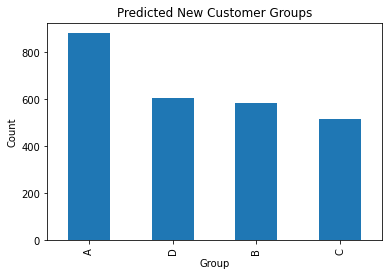

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the predicted customer groups
group_counts = new_customers_predicted['predicted_group'].value_counts()
group_counts.plot(kind='bar')

# Add plot labels
plt.title('Predicted New Customer Groups')
plt.xlabel('Group')
plt.ylabel('Count')

# Show the plot
plt.show()
